# VGG16 com Validação Cruzada
Este notebook aplica a rede **VGG16** utilizando os dados carregados pelo `DataLoader`, avaliando o desempenho via **validação cruzada (K-Fold)**.

# Importações Necessárias

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.keras.applications.efficientnet import preprocess_input # Pra conseguir treinar a efficient net
from tensorflow.keras.applications.resnet50 import preprocess_input

# Imports de classes dentro do projeto
from get_data_from_db import DataLoader
from create_model import create_vgg_model, create_efficientnet_model, create_resnet_model


# Obtendo os dados de treino

In [8]:
# Inicializa o DataLoader
data_loader = DataLoader()

# Carrega os dados de treino e validação com labels
train_data_with_labels = data_loader.get_train_data()   # dados de treino
val_data_with_labels   = list()     # dados de validação

# Junta os dois conjuntos
all_data_with_labels = train_data_with_labels + val_data_with_labels
print(f"Total de amostras (train + val): {len(all_data_with_labels)}")

IMG_SIZE = (224, 224)  # padrão para VGG16
X, y = [], []  # Vetores que vão armazenar os dados

# Reconstruindo caminho absoluto corretamente
for filename, label in all_data_with_labels:
    if label == 0:
        filepath = os.path.join(data_loader.train_normal_path, filename) \
                   if filename in os.listdir(data_loader.train_normal_path) \
                   else os.path.join(data_loader.val_normal_path, filename)
    elif label == 1:
        filepath = os.path.join(data_loader.train_ulcerative_colitis_path, filename) \
                   if filename in os.listdir(data_loader.train_ulcerative_colitis_path) \
                   else os.path.join(data_loader.val_ulcerative_colitis_path, filename)
    elif label == 2:
        filepath = os.path.join(data_loader.train_polyps_path, filename) \
                   if filename in os.listdir(data_loader.train_polyps_path) \
                   else os.path.join(data_loader.val_polyps_path, filename)
    elif label == 3:
        filepath = os.path.join(data_loader.train_esophagitis_path, filename) \
                   if filename in os.listdir(data_loader.train_esophagitis_path) \
                   else os.path.join(data_loader.val_esophagitis_path, filename)
    else:
        continue

    img = cv2.imread(filepath)
    if img is None:
        print(f"[AVISO] Não foi possível carregar: {filepath}")
        continue

    img = cv2.resize(img, IMG_SIZE)
    X.append(img)
    y.append(label)

X = np.array(X, dtype="float32")
y = to_categorical(np.array(y))

print(f"Formato de X: {X.shape}")
print(f"Formato de y: {y.shape}")


Dataset downloaded/cached at: C:\Users\Matheus\.cache\kagglehub\datasets\francismon\curated-colon-dataset-for-deep-learning\versions\1
Total de amostras (train + val): 3200
Formato de X: (3200, 224, 224, 3)
Formato de y: (3200, 4)


# VGG16

## Treinamento com Validação Cruzada

In [9]:

#Vai aplicar a validação cruzada K-Fold
n_folds = 2
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Treinando fold {fold+1}...")

    x_train_cv, x_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    model = create_vgg_model(input_shape=(224, 224, 3), num_classes=y.shape[1])
    model.fit(x_train_cv, y_train_cv,
              epochs=4, batch_size=32,
              validation_data=(x_val_cv, y_val_cv), verbose=1)

    _, acc = model.evaluate(x_val_cv, y_val_cv, verbose=0)
    accuracies.append(acc)

print("Acurácias por fold:", accuracies)
print("Acurácia média:", np.mean(accuracies))


Treinando fold 1...
Epoch 1/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 296s 6s/step - accuracy: 0.8875 - loss: 8.9354 - val_accuracy: 0.9850 - val_loss: 0.7808
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 281s 6s/step - accuracy: 0.9844 - loss: 0.8602 - val_accuracy: 0.9806 - val_loss: 0.9603
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 273s 6s/step - accuracy: 0.9856 - loss: 0.5231 - val_accuracy: 0.9825 - val_loss: 0.7892
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.9869 - loss: 0.4592 - val_accuracy: 0.9825 - val_loss: 0.9262
Treinando fold 2...
Epoch 1/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.8819 - loss: 7.4302 - val_accuracy: 0.9550 - val_loss: 1.8265
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.9719 - loss: 0.9529 - val_accuracy: 0.9819 - val_loss: 0.7415
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 273s 6s/step - accuracy: 0.9844 - loss: 0.7011 - val_accuracy: 0.9819 - val_loss: 0.7867
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 276s 6s/step - accuracy: 0.9825 - loss: 0

## Testando

In [10]:
# Pega todos os arquivos de teste com labels
test_files_with_labels = data_loader.get_test_data()
print(f"Total de amostras de teste: {len(test_files_with_labels)}")

IMG_SIZE = (224, 224)
X_test, y_test = [], []

# Carrega e processa as imagens de teste
for filename, label in test_files_with_labels:
    if label == 0:
        filepath = os.path.join(data_loader.test_normal_path, filename)
    elif label == 1:
        filepath = os.path.join(data_loader.test_ulcerative_colitis_path, filename)
    elif label == 2:
        filepath = os.path.join(data_loader.test_polyps_path, filename)
    elif label == 3:
        filepath = os.path.join(data_loader.test_esophagitis_path, filename)
    else:
        continue

    img = cv2.imread(filepath)
    if img is None:
        print(f"[AVISO] Não foi possível carregar: {filepath}")
        continue

    img = cv2.resize(img, IMG_SIZE)
    X_test.append(img)
    y_test.append(label)

# Normaliza e converte para categorical
X_test = np.array(X_test, dtype="float32") / 255.0
y_test = to_categorical(np.array(y_test))

print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_test: {y_test.shape}")

# Avalia o modelo já treinado
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"[TESTE FINAL] Loss: {loss:.4f}, Acurácia: {acc:.4f}")


Total de amostras de teste: 800
Formato de X_test: (800, 224, 224, 3)
Formato de y_test: (800, 4)
25/25 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.6313 - loss: 0.8126
[TESTE FINAL] Loss: 0.8126, Acurácia: 0.6313


## Grafico de Matriz de Confusão

25/25 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step


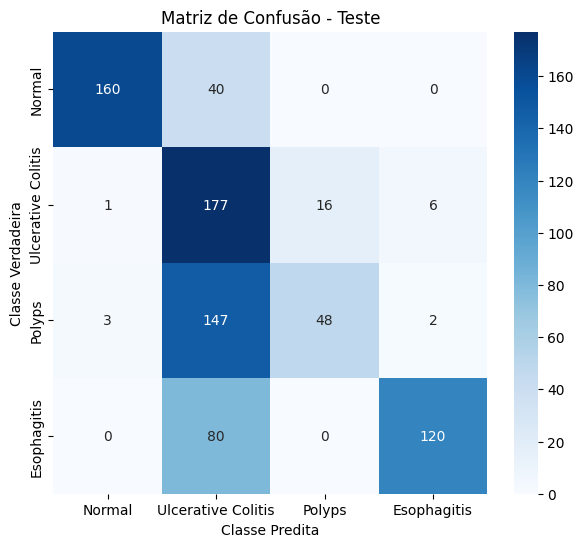


Relatório de Classificação:
                    precision    recall  f1-score   support

            Normal       0.98      0.80      0.88       200
Ulcerative Colitis       0.40      0.89      0.55       200
            Polyps       0.75      0.24      0.36       200
       Esophagitis       0.94      0.60      0.73       200

          accuracy                           0.63       800
         macro avg       0.77      0.63      0.63       800
      weighted avg       0.77      0.63      0.63       800



In [ ]:
# Converte y_test e predições de volta para labels inteiros
predicoes = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predicoes, axis=1)

# Labels das classes
classes = ["Normal", "Ulcerative Colitis", "Polyps", "Esophagitis"]

# Calcula a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Plota matriz de confusão
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.title('Matriz de Confusão - Teste')
plt.show()

# Relatório de classificação completo
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=classes))


# EfficientNet

In [12]:

#Vai aplicar a validação cruzada K-Fold
n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Treinando fold {fold+1}...")

    x_train_cv, x_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Normalização específica do EfficientNet
    x_train_cv = preprocess_input(x_train_cv)
    x_val_cv   = preprocess_input(x_val_cv)


    model = create_efficientnet_model(input_shape=(224, 224, 3), num_classes=y.shape[1])
    model.fit(x_train_cv, y_train_cv,
              epochs=20, batch_size=32,
              validation_data=(x_val_cv, y_val_cv), verbose=1)

    _, acc = model.evaluate(x_val_cv, y_val_cv, verbose=0)
    accuracies.append(acc)

print("Acurácias por fold:", accuracies)
print("Acurácia média:", np.mean(accuracies))


Treinando fold 1...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

# ResNet

## Treinando com validação cruzada

In [ ]:
# Vai aplicar a validação cruzada K-Fold
n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Treinando fold {fold+1}...")

    x_train_cv, x_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Normalização específica da ResNet50
    x_train_cv = preprocess_input(x_train_cv)
    x_val_cv   = preprocess_input(x_val_cv)

    model = create_resnet_model(input_shape=(224, 224, 3), num_classes=y.shape[1])
    model.fit(x_train_cv, y_train_cv,
              epochs=10, batch_size=32,
              validation_data=(x_val_cv, y_val_cv), verbose=1)

    _, acc = model.evaluate(x_val_cv, y_val_cv, verbose=0)
    accuracies.append(acc)

print("Acurácias por fold:", accuracies)
print("Acurácia média:", np.mean(accuracies))


## Testando

In [ ]:
# Pega todos os arquivos de teste com labels
test_files_with_labels = data_loader.get_test_data()
print(f"Total de amostras de teste: {len(test_files_with_labels)}")

IMG_SIZE = (224, 224)
X_test, y_test = [], []

# Carrega e processa as imagens de teste
for filename, label in test_files_with_labels:
    if label == 0:
        filepath = os.path.join(data_loader.test_normal_path, filename)
    elif label == 1:
        filepath = os.path.join(data_loader.test_ulcerative_colitis_path, filename)
    elif label == 2:
        filepath = os.path.join(data_loader.test_polyps_path, filename)
    elif label == 3:
        filepath = os.path.join(data_loader.test_esophagitis_path, filename)
    else:
        continue

    img = cv2.imread(filepath)
    if img is None:
        print(f"[AVISO] Não foi possível carregar: {filepath}")
        continue

    img = cv2.resize(img, IMG_SIZE)
    X_test.append(img)
    y_test.append(label)

# Normaliza e converte para categorical
X_test = np.array(X_test, dtype="float32") / 255.0
y_test = to_categorical(np.array(y_test))

print(f"Formato de X_test: {X_test.shape}")
print(f"Formato de y_test: {y_test.shape}")

# Avalia o modelo já treinado
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"[TESTE FINAL] Loss: {loss:.4f}, Acurácia: {acc:.4f}")
